In [1]:
import pandas as pd
from optuna.visualization import plot_optimization_history

from qsar.utils.visualizer import Visualizer
from qsar.utils.cross_validator import CrossValidator
from qsar.utils.extractor import Extractor
from qsar.utils.hyperparameter_optimizer import HyperParameterOptimizer

from qsar.models.xgboost import XgboostModel
from sklearn.preprocessing import StandardScaler

## 1. Data Import

In [2]:
data_paths = {
    "full_train": "../data/full/train/full_train_unfiltered.csv",
    "full_test": "../data/full/test/full_test_unfiltered.csv",
    "neutral_train": "../data/neutral/train/neutral_train_unfiltered.csv",
    "neutral_test": "../data/neutral/test/neutral_test_unfiltered.csv",
    "ionizable_train": "../data/ionizable/train/ionizable_train_unfiltered.csv",
    "ionizable_test": "../data/ionizable/test/ionizable_test_unfiltered.csv",
}

extractor = Extractor(data_paths)

# todo move the split after the preprocessing
x_dfs, y_dfs = extractor.split_x_y("Log_MP_RATIO")
df_full_tain = extractor.get_df("full_train")

## 2. Preprocessing

In [3]:
# Todo: include and review all the preprocessing steps
# Todo: check if we need scaling to make the model converge
# scaler = StandardScaler()
# x_full_train_scaled = scaler.fit_transform(x_dfs["full_train"])
# x_dfs["full_train"] = pd.DataFrame(x_full_train_scaled, index=x_dfs["full_train"].index, columns=x_dfs["full_train"].columns)
# x_full_test_scaled = scaler.transform(x_dfs["full_test"])
# x_dfs["full_test"] = pd.DataFrame(x_full_test_scaled, index=x_dfs["full_test"].index, columns=x_dfs["full_test"].columns)

## 3. Cross-validation

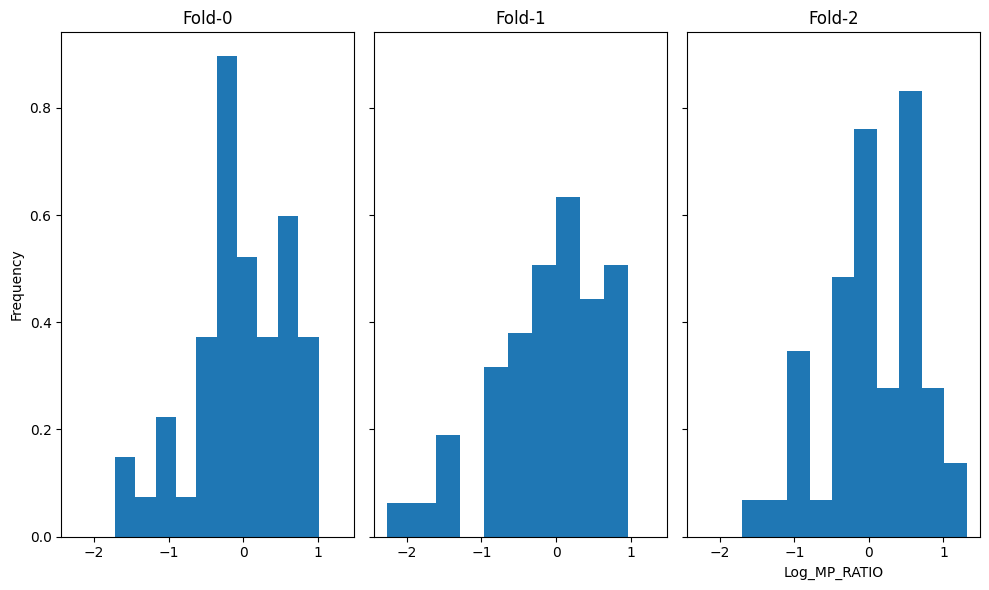

In [4]:
cross_validator = CrossValidator(df_full_tain)
visualizer = Visualizer()
X_list, y_list, df, y, n_folds = cross_validator.create_cv_folds()
visualizer.display_cv_folds(df, y, n_folds)

## 4. Model evaluation before hyperparameter optimization

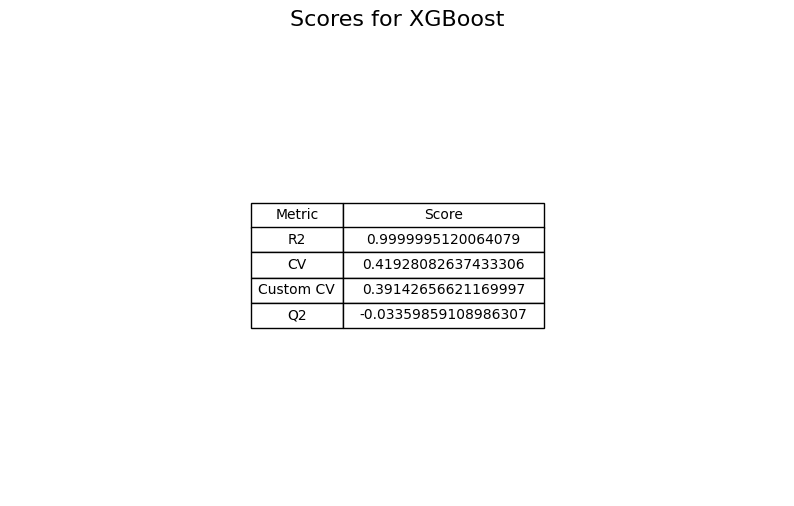

In [5]:
xgboost_model = XgboostModel()
R2, CV, custom_cv, Q2 = cross_validator.evaluate_model_performance(xgboost_model.model,
                                                                   x_dfs["full_train"], y_dfs["full_train"],
                                                                   x_dfs["full_test"], y_dfs["full_test"])
visualizer.display_model_performance("XGBoost", R2, CV, custom_cv, Q2)

## 5. Hyperparameter optimization

In [ ]:
xgboost_model = XgboostModel()

optimizer = HyperParameterOptimizer(model=xgboost_model, data=df_full_tain, direction='maximize', trials=100)

study = optimizer.optimize()
trial = study.best_trial
print(trial.value, trial.params)

[I 2023-11-28 15:48:21,015] A new study created in memory with name: no-name-088cd9a1-9af1-48e7-9091-610391d12d06


  0%|          | 0/100 [00:00<?, ?it/s]

## 6. Model evaluation after hyperparameter optimization

In [ ]:
xgboost_model.set_hyperparameters(**study.best_params)
R2, CV, custom_cv, Q2 = cross_validator.evaluate_model_performance(
    xgboost_model.model, x_dfs["full_train"], y_dfs["full_train"], x_dfs["full_test"], y_dfs["full_test"])
visualizer.display_model_performance("XGBoost", R2, CV, custom_cv, Q2)

In [ ]:
display(plot_optimization_history(study))

## 7. Prediction and results

In [ ]:
y_full_train_pred, y_full_test_pred = cross_validator.get_predictions(xgboost_model.model, x_dfs["full_train"],
                                                                      y_dfs["full_train"], x_dfs["full_test"])
visualizer.display_true_vs_predicted("XGBoost", y_dfs["full_train"], y_dfs["full_test"], y_full_train_pred, y_full_test_pred)